In [1]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import gsd
import gsd.hoomd
import hoomd
import hoomd.md
import hoomd.md.integrate
import time
import os
from polykit.generators.initial_conformations import grow_cubic


In [2]:
# setup the output folder with separate trajectory files for 
# the initial configuration, the optimized configuration, and the trajectory
OUT_ROOT_FOLDER = pathlib.Path('./example_traj/')
os.makedirs(OUT_ROOT_FOLDER, exist_ok=True)    
OUT_INIT_PATH = OUT_ROOT_FOLDER/'init.gsd'
OUT_OPTIMIZED_PATH = OUT_ROOT_FOLDER/'optimized.gsd'
OUT_TRAJ_PATH = OUT_ROOT_FOLDER/'traj.gsd'

In [3]:
# initialize simulation
try:
    current_device = hoomd.device.GPU()
    print(gpu.get_available_devices(), gpu.is_available())
except:
    current_device = hoomd.device.CPU()
    print('No GPU found, using CPU')

current_device = hoomd.device.CPU()
sim = hoomd.Simulation(device=current_device, seed=1)

No GPU found, using CPU


In [5]:
## set up particles, chains (i.e bonds), and density
N_CHAIN = 400
CHAINS = 10
number_of_monomers = N_CHAIN * CHAINS
DENSITY = 0.2

# Initialize particles
init_snapshot = gsd.hoomd.Frame()
init_snapshot.particles.N = number_of_monomers
init_snapshot.particles.types = ['CHROMATIN']
typeids = np.zeros(number_of_monomers, dtype=np.int32)
init_snapshot.particles.typeid = typeids

# Periodic boundary conditions set by density
BOX_SIZE = (number_of_monomers/DENSITY) ** (1/3.)
init_snapshot.configuration.box = [BOX_SIZE, BOX_SIZE, BOX_SIZE, 0, 0, 0]

# Create initial conformation and
# Set the initial positions of the particles.
init_positions = grow_cubic(N=number_of_monomers, 
                            boxSize=int(BOX_SIZE-1)).astype(float)
#center in the box
init_positions -= init_positions.mean(axis=0, keepdims=True)
init_snapshot.particles.position = init_positions


In [6]:
# Initialze bonds
def get_polymer_bonds(lo, hi, ring=False):
    bonds = np.vstack([np.arange(lo, hi-1), np.arange(lo+1, hi)]).T
    return bonds

polymer_bonds = np.zeros((0,2)).astype(int)#(n
for i in range(CHAINS):
    lo = int(i * N_CHAIN)
    hi = int((i+1) * N_CHAIN)
    polymer_bonds = np.vstack((polymer_bonds,get_polymer_bonds(lo, hi, ring=False)))

init_snapshot.bonds.N = polymer_bonds.shape[0] 
init_snapshot.bonds.types = ['polymer']
init_snapshot.bonds.typeid = np.zeros(polymer_bonds.shape[0])
init_snapshot.bonds.group = polymer_bonds
init_snapshot.bonds.validate()

In [7]:
# The initial configuration is saved into a file to be loaded immediately.
with gsd.hoomd.open(name=OUT_INIT_PATH, mode='w') as f:
    f.append(init_snapshot)

# set coordinates
sim.create_state_from_gsd(filename=OUT_INIT_PATH)

In [19]:
# creates forces, first bonds then non-bonded
bonded_forces = hoomd.md.bond.FENEWCA()
bonded_forces.params['polymer'] = dict(k=30.0, r0=1.5,epsilon=1.0,sigma=1.0,delta=0.0)

nlist = hoomd.md.nlist.Cell(buffer=0.4, exclusions=('bond',))

nonbonded_forces =hoomd.md.pair.LJ(nlist=nlist, default_r_cut=1.122462048309373)
nonbonded_forces.params[("CHROMATIN","CHROMATIN")]={"epsilon":1.0,"sigma":1.0}

thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
sim.operations.computes.append(thermodynamic_properties)

# note: subsets of particles can be easily selected: particle_filter = hoomd.filter.Type(['CHROMATIN'])


In [20]:
# perform inital energy minimization with FIRE (fast internal relaxation engine),
# before subjecting the system to LANGEVIN dyanamics

nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
fire = hoomd.md.minimize.FIRE(
    dt=0.0005,
    force_tol=5e-2,
    angmom_tol=5e-2,
    energy_tol=5e-2,
    forces=[bonded_forces, nonbonded_forces],
    methods=[nve])
sim.operations.integrator = fire

gsd_optimized_writer = hoomd.write.GSD(
    filename=OUT_OPTIMIZED_PATH,
    trigger=hoomd.trigger.Periodic(1000),
    mode='wb')
sim.operations.writers.append(gsd_optimized_writer)

sim.run(0)
print(f'kin temp = {thermodynamic_properties.kinetic_temperature},  E_P/N = {thermodynamic_properties.potential_energy / number_of_monomers}')
for i in range(100):
    sim.run(1000)
    print(f'kin temp = {thermodynamic_properties.kinetic_temperature},   E_P/N = {thermodynamic_properties.potential_energy / number_of_monomers}')
    gsd_optimized_writer.write(sim.state, gsd_optimized_writer.filename)

# remove the forces and writers from the integrator
# so that they can be attached to the new integrator
for _ in range(len(fire.forces)):
    fire.forces.pop()
sim.operations.writers.pop(0)


kin temp = 0.0,  E_P/N = 20.389964840595464
kin temp = 0.000346689599491982,   E_P/N = 20.007424992894098
kin temp = 0.000346689599491982,   E_P/N = 20.007424992894098
kin temp = 0.000346689599491982,   E_P/N = 20.007424992894098
kin temp = 0.000346689599491982,   E_P/N = 20.007424992894098
kin temp = 0.000346689599491982,   E_P/N = 20.007424992894098
kin temp = 0.000346689599491982,   E_P/N = 20.007424992894098
kin temp = 0.000346689599491982,   E_P/N = 20.007424992894098
kin temp = 0.000346689599491982,   E_P/N = 20.007424992894098
kin temp = 0.000346689599491982,   E_P/N = 20.007424992894098
kin temp = 0.000346689599491982,   E_P/N = 20.007424992894098
kin temp = 0.000346689599491982,   E_P/N = 20.007424992894098
kin temp = 0.000346689599491982,   E_P/N = 20.007424992894098
kin temp = 0.000346689599491982,   E_P/N = 20.007424992894098
kin temp = 0.000346689599491982,   E_P/N = 20.007424992894098
kin temp = 0.000346689599491982,   E_P/N = 20.007424992894098
kin temp = 0.0003466895994

In [21]:
# setup LANGEVIN dyanmics

# langevin integrator paraemeters
NUM_BLOCKS = 1000
BLOCK_SIZE = 100
LANGEVIN_TIMESTEP= 0.01

# Initialize integrators and Langevin thermostat
langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0)

run_integrator = hoomd.md.Integrator(
    dt=LANGEVIN_TIMESTEP, 
    methods=[langevin], 
    forces=[bonded_forces, nonbonded_forces])
sim.operations.integrator = run_integrator

gsd_writer = hoomd.write.GSD(
    filename=OUT_TRAJ_PATH,
    trigger=hoomd.trigger.Periodic(BLOCK_SIZE),
    dynamic=['property','momentum'],
    mode='wb')

sim.operations.writers.append(gsd_writer)


In [22]:
# run langevin dyanmics
snapshots = []

sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.0)
for cur_step in range(0, NUM_BLOCKS):
    start=time.time()
    sim.run(BLOCK_SIZE)
    print(f'kin temp = {thermodynamic_properties.kinetic_temperature}, E_P/N = {thermodynamic_properties.potential_energy / number_of_monomers}')



kin temp = 0.9302462529761272, E_P/N = 20.30652371008768
kin temp = 1.0003176072008233, E_P/N = 20.41291400433399
kin temp = 0.9950745943206968, E_P/N = 20.50741161582271
kin temp = 1.0232260659069925, E_P/N = 20.537544848071942
kin temp = 1.0092253907343973, E_P/N = 20.541304581713696
kin temp = 1.0049281570302886, E_P/N = 20.537696343190756
kin temp = 0.9957292909571606, E_P/N = 20.577240449772383
kin temp = 1.000758027012085, E_P/N = 20.591563187868804
kin temp = 1.0090506291861145, E_P/N = 20.594177411488804
kin temp = 1.0034982961697183, E_P/N = 20.567198429434715
kin temp = 1.0046317711872015, E_P/N = 20.58913446628929
kin temp = 0.9998754530580253, E_P/N = 20.606314737849164
kin temp = 1.0205940142340886, E_P/N = 20.600042360572775
kin temp = 0.9999214908617934, E_P/N = 20.577396065597025
kin temp = 1.0027495584174895, E_P/N = 20.570887552288372
kin temp = 0.996005633110381, E_P/N = 20.600591246475155
kin temp = 0.9936895556737831, E_P/N = 20.638817057106376
kin temp = 0.9929245

KeyboardInterrupt: 

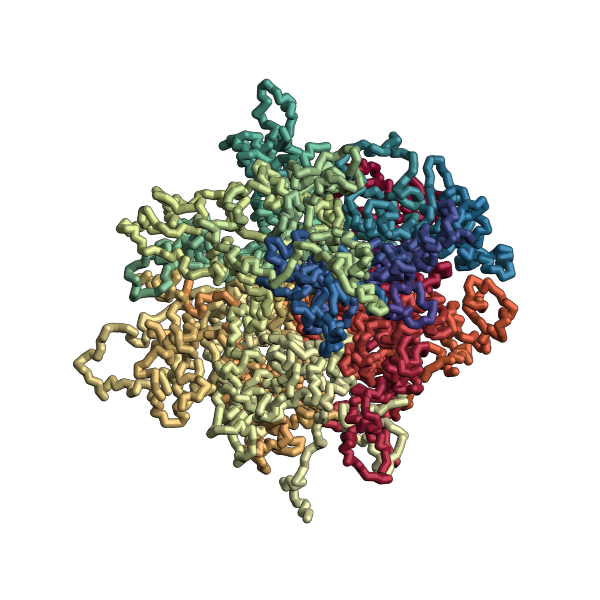

In [26]:
import polychrom_hoomd.render as render
snapshot_relaxed= sim.state.get_snapshot()
render.fresnel(snapshot_relaxed, cmap="Spectral").static(pathtrace=False)

